In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import glob
import time

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import torch.utils.data as Data

from scipy.signal import savgol_filter as savgol
from datetime import datetime
import random

%matplotlib inline

### GPU

In [2]:
!pwd

/Users/cagrierdem/Desktop/dev/guitDATA/notebooks/modelv1/emg-to-rms


In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu") #2nd 1080
torch.backends.cudnn.benchmark = True
print('(Train on the {})\n'.format(device))

print(torch.backends.cudnn.version())
torch.backends.cudnn.enabled = False

(Train on the cpu)

None


### Import

In [11]:
# npy_dir = '/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/'
# model_dir = "/home/cagrie/Desktop/cagrie/code/emg-to-rms/models/torch/"
# save_dir = "/home/cagrie/Desktop/cagrie/code/emg-to-rms/models/torch/torch_preds/"

npy_dir = '/Users/cagrierdem/Desktop/dat/modelv1/emg-rms_raw-npy/'
pred_dir = "/Users/cagrierdem/Desktop/dev/guitDATA/notebooks/modelv1/emg-to-rms/models/torch/torch_preds/"
plot_dir = '/Users/cagrierdem/Downloads/new_plots/' # pred_dir + 'plots/'
model_dir = "/Users/cagrierdem/Desktop/dev/guitDATA/notebooks/modelv1/emg-to-rms/models/torch/"

people = list(filter(lambda x: "2019" in x and ("p0" in x or "p1" in x or "p2" in x), os.listdir(npy_dir)))

tasks = [
  'sustained_soft_70',
  'iterative_soft_70',
  'on-off_soft_70',
  'bending_soft_70',
  'sustained_strong_70',
  'iterative_strong_70',
  'on-off_strong_70',
  'bending_strong_70',
  'free_70'
]

batch_size = 100 # batch size, can be changed
num_train = 20
total_epoches = 20
loss_list = []
window_size = 50
hidden_size = 64
n_layers=2
lr=0.001

INPUT_DIMS=16

In [4]:
# date_string = datetime.today().strftime('%Y%m%d-%H_%M_%S')
# model_name = f"Modelv1-{date_string}-{hidden_size}-{INPUT_DIMS}-{num_train}\
# -{window_size}-{batch_size}-{str(lr).replace('.','_')}"
# print(model_name)

In [5]:
models=[]
for path in os.listdir(path=model_dir):
    if path.startswith('Modelv1') and not path.endswith('.npy'):
        models.append(path)
models = sorted(models)

In [6]:
#date - h_m_s - units - dims - epoch - window - batch - lr - layers? 
models

['Modelv1-20191122-66_66_66-32-16-20-50-100-0_001',
 'Modelv1-20201107-16_35_21-128-16-15-50-100-0_001',
 'Modelv1-20201107-16_48_46-32-16-20-50-100-0_001',
 'Modelv1-20201107-21_15_47-256-16-20-50-100-0_001',
 'Modelv1-20201108-03_20_10-64-16-20-50-100-0_001',
 'Modelv1-20201108-03_30_54-128-16-20-50-100-0_001',
 'Modelv1-20201108-11_50_11-16-16-20-50-100-1-0_001',
 'Modelv1-20201108-11_50_22-32-16-20-50-100-1-0_001',
 'Modelv1-20201108-11_51_29-64-16-20-50-100-1-0_001',
 'Modelv1-20201108-16_04_55-16-16-20-50-100-5-0_001',
 'Modelv1-20201108-20_37_11-16-16-20-50-100-2-0_001',
 'Modelv1-20201109-11_05_30-64-16-20-50-100-2-0_001',
 'Modelv1-20201109-11_11_53-64-16-20-50-100-5-0_01']

In [10]:
models.index('Modelv1-20201109-11_05_30-64-16-20-50-100-2-0_001')

11

### Model_torch

In [12]:
class RNN(nn.Module): 
    def __init__(self):
        super(RNN, self).__init__()    
        self.rnn = nn.LSTM(
            input_size=window_size,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.out = nn.Tanh()
    def forward(self, x):
        x, _ = self.rnn(x, None)
        x = self.linear(x)
        x = self.relu(x)
        x = self.out(x)
        x = torch.mean(x, dim=1).view(x.shape[0], 1) 
        return x
    
model = RNN().to(device)

print(model)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

RNN(
  (rnn): LSTM(50, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (out): Tanh()
)


In [13]:
modelname = models[11]
model_path = os.path.join(model_dir, modelname)
print(model_path)

/Users/cagrierdem/Desktop/dev/guitDATA/notebooks/modelv1/emg-to-rms/models/torch/Modelv1-20201109-11_05_30-64-16-20-50-100-2-0_001


In [14]:
#load the model
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) 

<All keys matched successfully>

In [15]:
#helper functions
def printProgressBar(i,max,postText):
    n_bar =10 #size of progress bar
    j= i/max
    sys.stdout.write('\r')
    sys.stdout.write(f"[{'=' * int(n_bar * j):{n_bar}s}] {int(100 * j)}%  {postText}")
    sys.stdout.flush()

def norm(l, min_val=0):
    max_value = max(l)
    min_value = min(l)
    k = []
    for i in range(0, len(l)):
        if min_val == 0:
            k.append((l[i] - min_value) / (max_value - min_value))
        elif min_val == -1:
            k.append( 2*(l[i] - min_value) / (max_value - min_value)-1 )
    return np.array(k)

def match(x,y):
    if x.shape[0] > y.shape[0]:
        x = x[:y.shape[0]]
    else:
        y = y[:x.shape[0]]
    return x,y

def test_load(t_path, participant, task):
    testpath = os.path.join(t_path, participant, task)
    print(testpath)
    test_r = np.load(testpath + '/emgr_raw.npy')
    test_l = np.load(testpath + '/emgl_raw.npy')
    test_rms = np.load(testpath + '/sound_rms.npy')
    if test_r.shape[1] > test_l.shape[1]:
        test_r = test_r[:, :test_l.shape[1]]
    else:
        test_l = test_l[:, :test_r.shape[1]]
    test = np.concatenate((test_r, test_l), axis=0)
    return test, test_rms

def test(trained_model, test_data, window_size=50):
    test = torch.Tensor(test_data).to(device)
    out = []
    for i in range(test.shape[1] - window_size):
        pred = trained_model(test[:, i:i + window_size].unsqueeze(0))
        pred = pred.cpu().detach().numpy()
        out.append(pred)
        if i % 10000 == 0:
            print(i)
    out = np.array(out)     
    return np.squeeze(out)

def filt(x, win=5999, order=1, normalize=True):
    if normalize:
        x = norm(x)
    return savgol(x, win, order)

def plot(rms, pred, win=499, tplot=True):
    plt.figure(figsize=(24, 7))
    if tplot:
        plt.plot(rms[:len(pred)], label="True RMS", alpha=0.4)
    plt.plot(pred, label="Predicted RMS", alpha=0.2)
    plt.plot(filt(pred, win=win), label="Predicted RMS", alpha=0.7, color='r')
    plt.legend(loc="upper right")
    plt.show()

### Predict

In [16]:
sorted(people)

['p01_20191008',
 'p02_20191111',
 'p03_20191111',
 'p04_20191007',
 'p05_20191007',
 'p06_20191007',
 'p07_20191008',
 'p08_20191008',
 'p09_20191009',
 'p10_20191009',
 'p11_20191111',
 'p12_20191009',
 'p13_20191017',
 'p14_20191017',
 'p15_20191017',
 'p16_20191018',
 'p17_20191018',
 'p18_20191024',
 'p19_20191024',
 'p20_20191024',
 'p21_20191025',
 'p22_20191025',
 'p24_20191101',
 'p25_20191101',
 'p26_20191108',
 'p27_20191108',
 'p28_20191108']

In [222]:
#free improv test
test_free_emg, test_free_rms = test_load(npy_dir, people[-2], "free_70")
print(test_free_emg.shape, test_free_rms.shape)
pred_free = test(trained_model=model, test_data=test_free_emg, window_size=50)

/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p20_20191024/free_70
(16, 64344) (64337,)
0
10000
20000
30000
40000
50000
60000


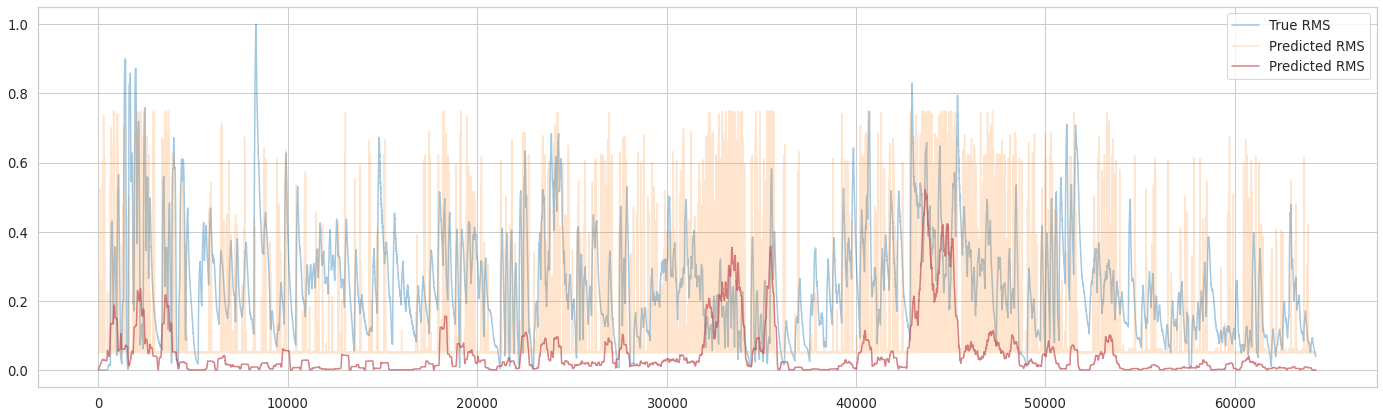

In [231]:
plot(test_free_rms, pred_free, win=399)

In [14]:
# #task test
# test_imp_emg, test_imp_rms = test_load(npy_dir, people[-2], "sustained_strong_70")
# print(test_imp_emg.shape, test_imp_rms.shape)
# pred_imp = test(trained_model=model, test_data=test_imp_emg, window_size=50)

In [15]:
# plot(test_imp_rms, pred_imp, win=499)

### Save predictions to file

In [226]:
test_data=[]
for peep in sorted(people):
    try:
        tdat = test_load(npy_dir, peep, "free_70")
        test_data.append(tdat)
    except:
        print(peep)

/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p01_20191008/free_70
/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p02_20191111/free_70
/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p03_20191111/free_70
/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p04_20191007/free_70
/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p05_20191007/free_70
/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p06_20191007/free_70
/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p07_20191008/free_70
/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p08_20191008/free_70
/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p09_20191009/free_70
/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p10_20191009/free_70
/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p11_20191111/free_70
/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p12_20191009/free_70
/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p13_20191017/free_70
p13_20191017
/home/cagrie/Desktop/cagrie/code/emg-rms_raw-npy/p14_20191017/free_70
/home/c

In [227]:
start_time = time.time()

predictions=[]
for i, dat in enumerate(test_data):
    try:
        prediction = test(trained_model=model, test_data=dat[0], window_size=50)
        print('Predicted nr:', i+1)
        predictions.append(prediction)
    except:
        pass
    printProgressBar(i,len(test_data),"completed")

elapsed_time = time.time() - start_time
print("Execution of this program took %s seconds." % (elapsed_time))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
Predicted nr: 1
[          ] 0%  completed0
10000
20000
30000
40000
50000
60000
70000
Predicted nr: 2
[          ] 4%  completed0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
Predicted nr: 3
[          ] 8%  completed0
10000
20000
30000
40000
50000
Predicted nr: 4
[=         ] 12%  completed0
10000
20000
30000
40000
50000
60000
70000
Predicted nr: 5
[=         ] 16%  completed0
10000
20000
30000
40000
50000
60000
70000
80000
Predicted nr: 6
[==        ] 20%  completed0
10000
20000
30000
40000
50000
60000
Predicted nr: 7
[==        ] 24%  completed0
10000
20000
30000
40000
50000
60000
70000
Predicted nr: 8
[==        ] 28%  completed0
10000
20000
30000
40000
50000
60000
Predicted nr: 9
[===       ] 32%  completed0
10000
20000
30000
Predicted nr: 10
[===       ] 36%  completed0
10000
20000
30000
40000
50000
60000
70000
Predicted nr: 11
[====      ] 40%  completed0
10000
20000
30000
40000
50000
60000
70000
Predicted n

In [228]:
print(modelname)
for pred in predictions:
    print(pred.shape)

Modelv1-20201109-11_11_53-64-16-20-50-100-5-0_01
(99001,)
(77071,)
(102217,)
(55152,)
(78597,)
(88584,)
(67351,)
(73671,)
(66521,)
(32626,)
(72928,)
(78150,)
(119121,)
(48331,)
(66729,)
(112966,)
(84415,)
(64294,)
(132235,)
(115495,)
(61706,)
(64504,)
(82925,)
(48514,)
(72778,)


In [229]:
round(elapsed_time/25/60, 2)

6.53

In [230]:
for i, pred in enumerate(predictions[:num_train]):
    p_name = str(sorted(people)[i])
    print(p_name, pred.shape)
    np.save(os.path.join(save_dir, modelname + '_' + p_name.split('_')[0] + '.npy'), pred)
    
#save a txt file with the data info
with open(os.path.join(save_dir, modelname + "_pred_time.txt"), "w") as text_file:
    print(' \n'.join([str(elem) for elem in [elapsed_time]]) , file=text_file)

p01_20191008 (99001,)
p02_20191111 (77071,)
p03_20191111 (102217,)
p04_20191007 (55152,)
p05_20191007 (78597,)
p06_20191007 (88584,)
p07_20191008 (67351,)
p08_20191008 (73671,)
p09_20191009 (66521,)
p10_20191009 (32626,)
p11_20191111 (72928,)
p12_20191009 (78150,)
p13_20191017 (119121,)
p14_20191017 (48331,)
p15_20191017 (66729,)
p16_20191018 (112966,)
p17_20191018 (84415,)
p18_20191024 (64294,)
p19_20191024 (132235,)
p20_20191024 (115495,)


In [ ]:
stoppppppppp

### import the best!

In [17]:
#IMPRO
impro_emg, impro_rms = test_load(npy_dir, sorted(people)[-2], "free_70")
print(impro_emg.shape, impro_rms.shape)
pred_impro = test(trained_model=model, test_data=impro_emg, window_size=50)

/Users/cagrierdem/Desktop/dat/modelv1/emg-rms_raw-npy/p27_20191108/free_70
(16, 48564) (48549,)
0
10000
20000
30000
40000


In [18]:
#IMPULSIVE
impulsive_emg, impulsive_rms = test_load(npy_dir, sorted(people)[-2], "sustained_strong_70")
print(impulsive_emg.shape, impulsive_rms.shape)
pred_impulsive = test(trained_model=model, test_data=impulsive_emg, window_size=50)

/Users/cagrierdem/Desktop/dat/modelv1/emg-rms_raw-npy/p27_20191108/sustained_strong_70
(16, 25330) (25316,)
0
10000
20000


In [19]:
#ITERATIVE
iterative_emg, iterative_rms = test_load(npy_dir, sorted(people)[-2], "iterative_strong_70")
print(iterative_emg.shape, iterative_rms.shape)
pred_iterative = test(trained_model=model, test_data=iterative_emg, window_size=50)

/Users/cagrierdem/Desktop/dat/modelv1/emg-rms_raw-npy/p27_20191108/iterative_strong_70
(16, 25360) (25346,)
0
10000
20000


In [20]:
#BENDING
bending_emg, bending_rms = test_load(npy_dir, sorted(people)[-2], "bending_strong_70")
print(bending_emg.shape, bending_rms.shape)
pred_bending = test(trained_model=model, test_data=bending_emg, window_size=50)

/Users/cagrierdem/Desktop/dat/modelv1/emg-rms_raw-npy/p27_20191108/bending_strong_70
(16, 25605) (25601,)
0
10000
20000


In [21]:
#LEGATO
legato_emg, legato_rms = test_load(npy_dir, sorted(people)[-2], "on-off_strong_70")
print(legato_emg.shape, legato_rms.shape)
pred_legato = test(trained_model=model, test_data=legato_emg, window_size=50)

/Users/cagrierdem/Desktop/dat/modelv1/emg-rms_raw-npy/p27_20191108/on-off_strong_70
(16, 25368) (25360,)
0
10000
20000


In [22]:
air_tasks = ['air_guit_iterative', 'air_guit_sustained', 'air_guit_free']
air_takes = ['', '_c', '_c2', '_c3']
air_dir = "/Users/cagrierdem/Desktop/dat/modelv1/air_guitar-npy/"

#AIR IMPULSIVE
task = air_tasks[1]
take = air_takes[2]
air_dir = os.path.join(air_dir, task, task + take) + '/'

air_impulsive_emg, air_impulsive_rms = test_load(air_dir, '', '')
print(air_impulsive_emg.shape, air_impulsive_rms.shape)
pred_air_sus = test(trained_model=model, test_data=air_impulsive_emg, window_size=50)

/Users/cagrierdem/Desktop/dat/modelv1/air_guitar-npy/air_guit_sustained/air_guit_sustained_c2/
(16, 25466) (25464,)
0
10000
20000


In [24]:
#AIR ITERATIVE
air_dir = "/Users/cagrierdem/Desktop/dat/modelv1/air_guitar-npy/"
task = air_tasks[0]
take = air_takes[2]
air_dir = os.path.join(air_dir, task, task + take) + '/'

air_iterative_emg, air_iterative_rms = test_load(air_dir, '', '')
print(air_iterative_emg.shape, air_iterative_rms.shape)
pred_air_iterative = test(trained_model=model, test_data=air_iterative_emg, window_size=50)

/Users/cagrierdem/Desktop/dat/modelv1/air_guitar-npy/air_guit_iterative/air_guit_iterative_c2/
(16, 25500) (25502,)
0
10000
20000


### Plot the best!

In [28]:
sns.set(style="whitegrid", font_scale=2.2)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
pals = ["tab10", 'magma', 'rocket_r', "ch:s=-.0002, r=1.6", 'cubehelix', colors]
current_palette = sns.color_palette(pals[-1])
sns.set_palette(current_palette)
# img_dir = "/home/cagrie/Desktop/cagrie/code/emg-to-rms/models/torch/torch_preds/plots/"
img_dir = plot_dir

In [50]:
def fin_plot(rms, pred, win=499, tplot=True, title='', truet=2.5, palpha=0.3, disx=False, xlab="Time (s)",
             loc="upper right", match2=False, save=False, leg_pos=(0.5, 0.5), framealpha=0.01):
    
    if match2:
        rms, pred = match(rms, pred)
    time = np.linspace(0, len(pred)/200, len(pred))
    plt.figure(figsize=(24, 7))
    if tplot:
        plt.plot(time,rms[:len(pred)], label="True", alpha=0.7, linewidth=truet)
    plt.plot(time,pred, label="Prediced", alpha=palpha)
    plt.plot(time,filt(pred, win=win), label="Pred. (filt.)", alpha=0.8, color='r' , linewidth=3.0)
    plt.legend(loc=loc, fontsize=30, framealpha=framealpha, bbox_to_anchor=leg_pos)
    plt.xlabel(xlab, fontsize=30)
    if disx:
        plt.xticks([])
    else:
        plt.xticks(fontsize=27)
    plt.ylabel('RMS', fontsize=30)
    plt.yticks(fontsize=27)
    plt.title(title, fontsize=35)
    if save:
        plt.savefig(os.path.join(img_dir, 'predicted_'+title+".png"), bbox_inches='tight')
    plt.ylim(0,1)
    plt.show()

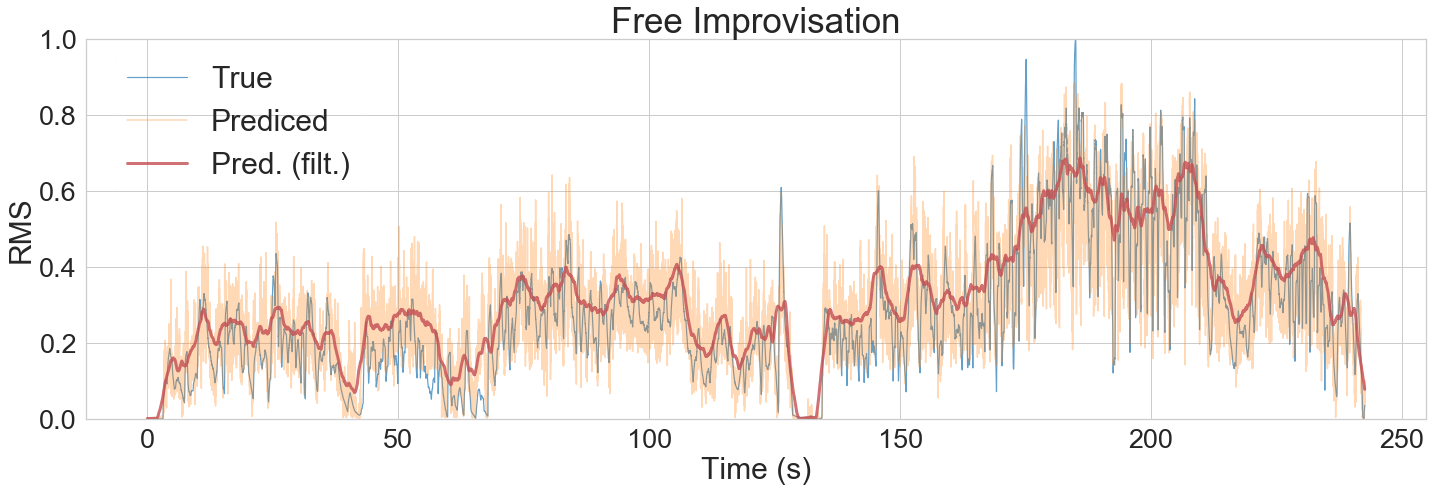

In [96]:
fin_plot(impro_rms, pred_impro, win=499, title='Free Improvisation', truet=1.2, palpha=0.3,
         match2=True, loc="upper left", disx=False, save=False, leg_pos=(0.01, 1))

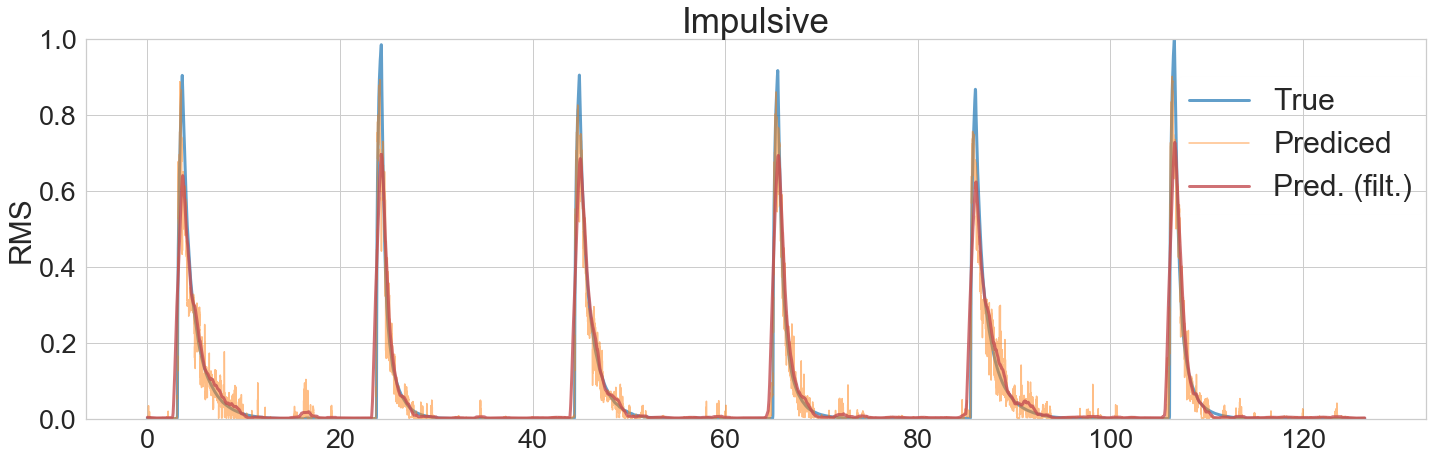

In [97]:
fin_plot(impulsive_rms, pred_impulsive, win=199, title='Impulsive', truet=3.0, palpha=0.5,
         loc="lower right", save=False, disx=False, xlab='', leg_pos=(1.01, 0.5))

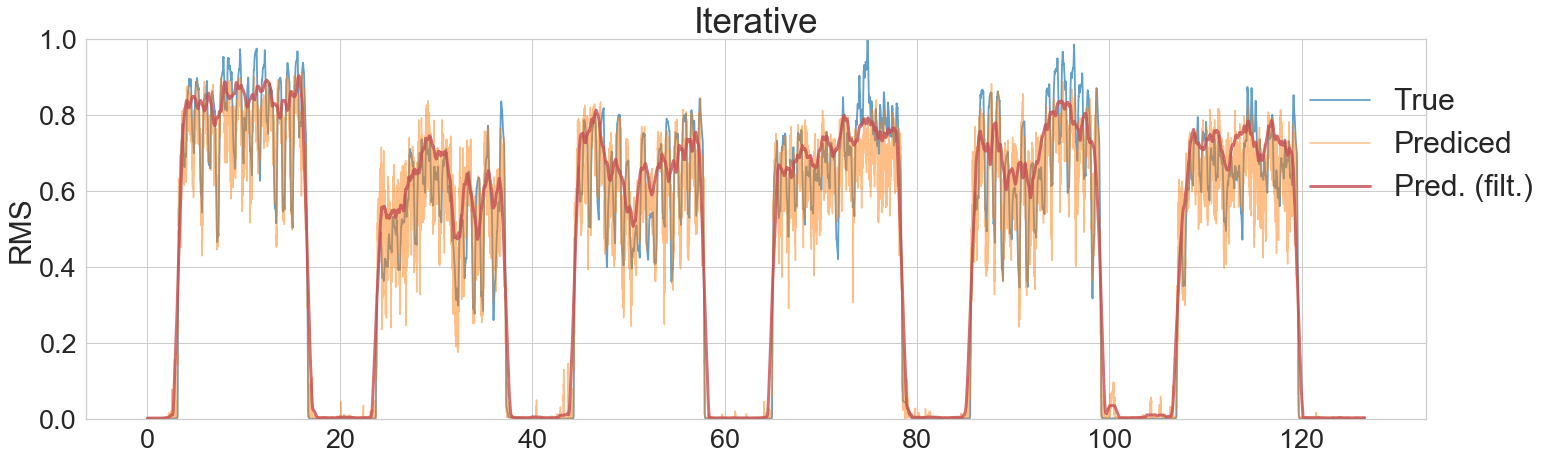

In [98]:
fin_plot(iterative_rms, pred_iterative, win=199, title='Iterative', truet=1.8,  palpha=0.5,
         loc="lower right", disx=False, save=False, xlab='', leg_pos=(1.1, 0.5))

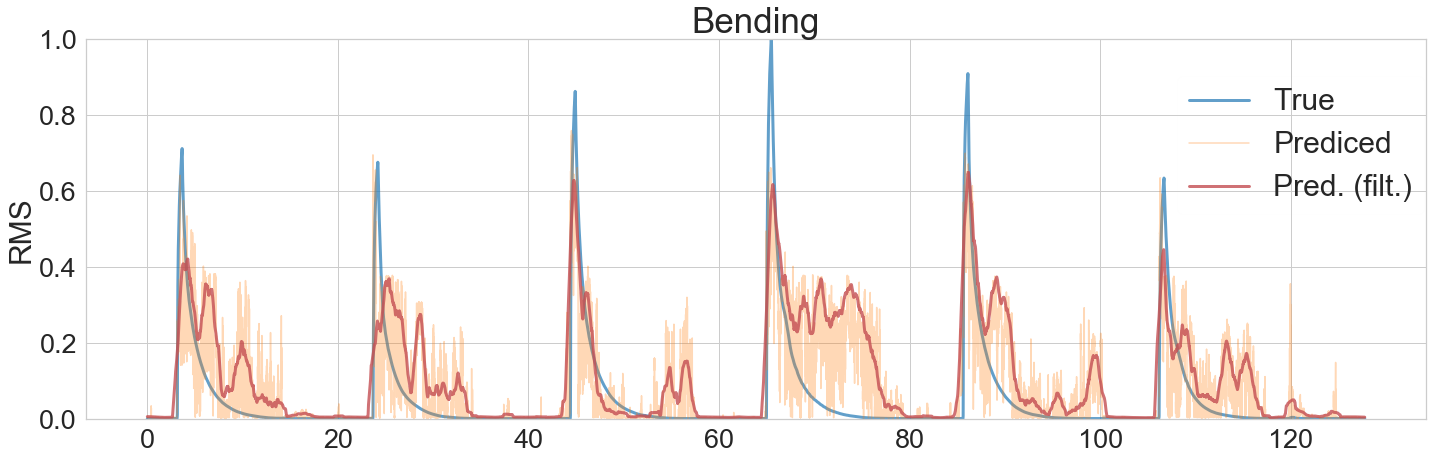

In [99]:
fin_plot(bending_rms, pred_bending, win=199, tplot=True, title='Bending', loc="lower right",
         truet=3, disx=False, save=False, xlab='', leg_pos=(1.01, 0.5))

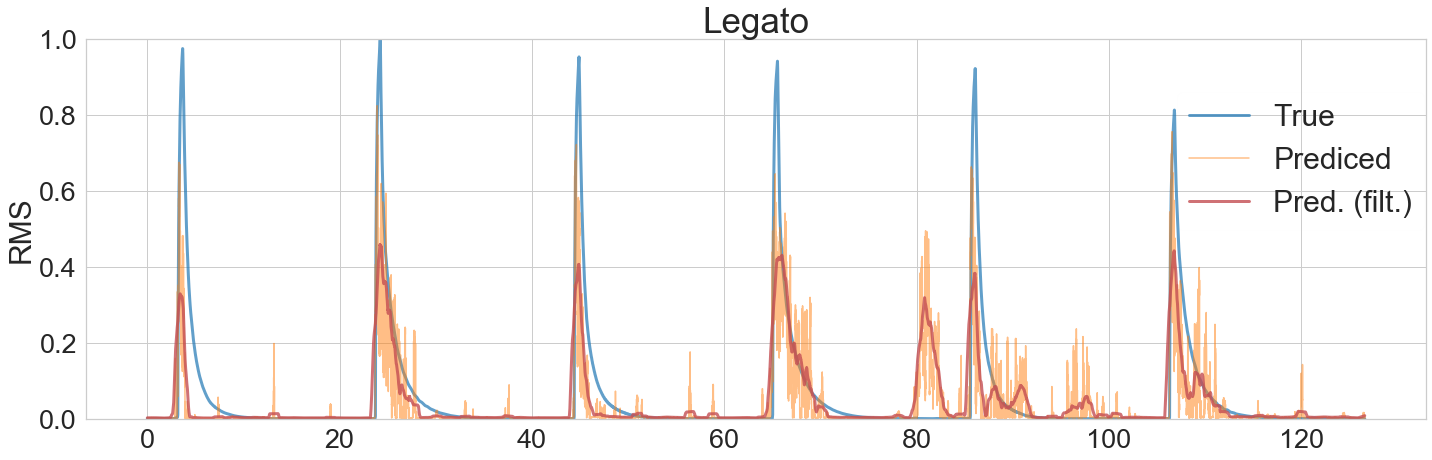

In [100]:
fin_plot(legato_rms, pred_legato, win=199, title='Legato',  palpha=0.5,
         truet=3, disx=False, save=False, xlab='', leg_pos=(1.01, 0.9))

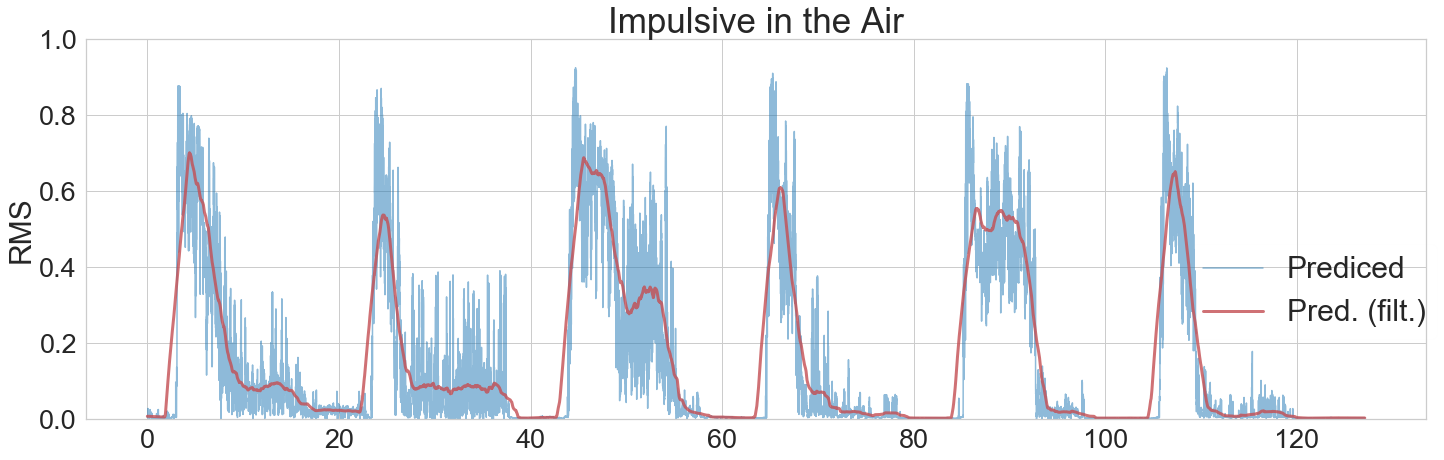

In [103]:
fin_plot(air_impulsive_rms, pred_air_sus, win=499, tplot=False, palpha=0.5,
         title="Impulsive in the Air", disx=False, save=False, xlab='', leg_pos=(1.02, 0.5))

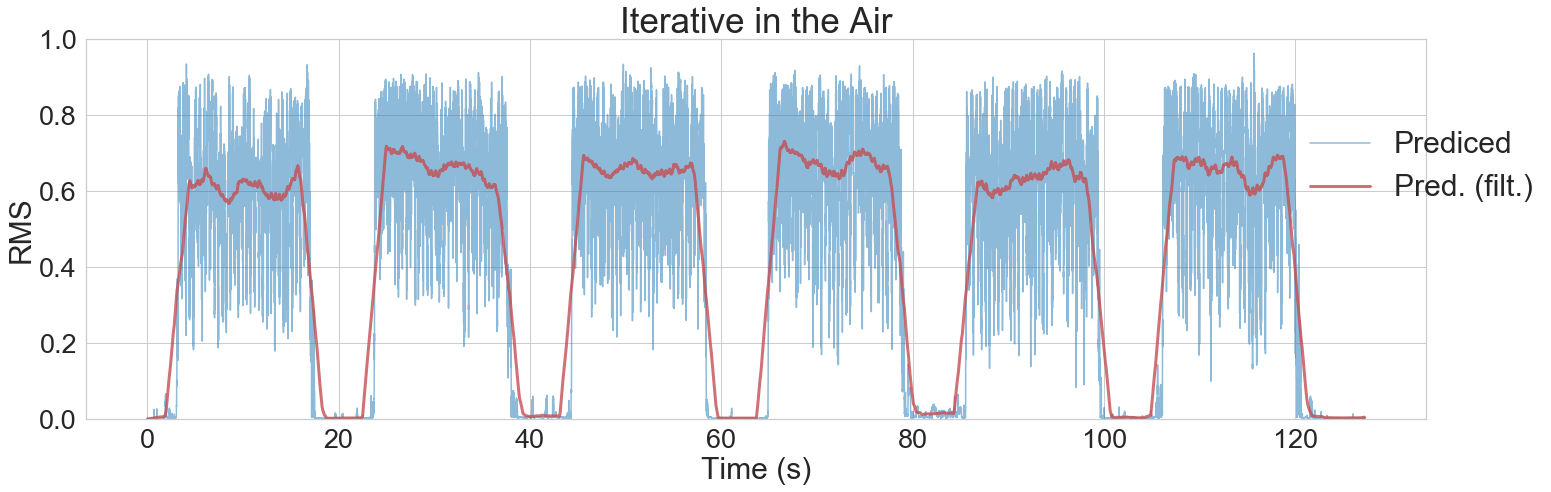

In [102]:
fin_plot(air_iterative_rms, pred_air_iterative, win=499, tplot=False, palpha=0.5,
         loc="lower right",title="Iterative in the Air", disx=False, save=False, leg_pos=(1.1, 0.5))